# CO2 Emissions Analysis — Final Project

**Author:** Łukasz Szota  
**Date:** 03.12.2025
**Course:** WINC Academy — Data Analytics with Python

---

## Research Questions

This notebook explores three questions about global CO2 emissions using data from Our World in Data:

1. **Q1:** What is the biggest predictor of a large CO2 output per capita of a country?
2. **Q2:** Which countries are making the biggest strides in decreasing CO2 output?
3. **Q3:** Which non-fossil fuel energy technology will have the best price in the future?

## About the Data

Data comes from [Our World in Data](https://ourworldindata.org/) — they compile statistics from sources like Global Carbon Project and IRENA. I chose this dataset becuase it's well-documented and updated regulary.

---

In [1]:
# --- Setup: imports and config ---

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LinearRegression

# display settings - makes dataframes easier to read
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 200)

# plot styling
# tried a few different styles, this one looks cleanest imo
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

print("Libraries loaded")

Libraries loaded


In [2]:
# --- Settings and constants ---

# putting all the parameters here so its easier to change later
SETTINGS = {
    'q1_year': None,  # will set this to latest year with full data

    # for Q2 trend analysis - comparing 2013 to now
    'q2_baseline_year': 2013,
    'q2_current_year': None,
    'q2_min_population': 1_000_000,  # filter out tiny countries
    'q2_top_n': 15,

    # Q3 forecast
    'q3_forecast_years': [2025, 2030],

    # data url - from OWID github
    'data_url': "https://raw.githubusercontent.com/owid/co2-data/master/owid-co2-data.csv",
}

# these are not real countries, just aggregates that mess up the analysis
# took me a while to figure out why my numbers were wrong lol
EXCLUDE_LIST = [
    'World', 'Africa', 'Asia', 'Europe', 'North America', 'South America', 'Oceania',
    'European Union (27)', 'European Union (28)',
    'High-income countries', 'Low-income countries',
    'Lower-middle-income countries', 'Upper-middle-income countries',
    'Asia (excl. China and India)', 'Europe (excl. EU-27)', 'Europe (excl. EU-28)',
    'North America (excl. USA)', 'International transport',
    'International aviation', 'International shipping'
]

print("Settings ready")

Settings ready


In [3]:
# --- Helper functions ---
# wrote these to avoid repeating code, some of them I might reuse in other projects

def load_csv_from_url(url, error_msg="Could not load data"):
    """Load CSV from URL, returns None if it fails"""
    try:
        df = pd.read_csv(url)
        print(f"Loaded {df.shape[0]:,} rows, {df.shape[1]} cols")
        return df
    except Exception as e:
        print(f"ERROR: {error_msg}")
        print(f"  Details: {e}")
        return None


def get_countries_only(df, country_col='country', iso_col='iso_code', exclude=None):
    """
    Filters out aggregates like 'World', 'Europe' etc.
    Only keeps rows with valid 3-letter ISO codes
    """
    if exclude is None:
        exclude = []

    # iso code should be exactly 3 characters for real countires
    mask = (
        (df[iso_col].notna()) &
        (df[iso_col].str.len() == 3) &
        (~df[country_col].isin(exclude))
    )

    result = df[mask].copy()
    print(f"Filtered: {df[country_col].nunique()} entities -> {result[country_col].nunique()} countries")
    return result


def calc_correlations(df, target, predictors):
    """
    Calculates pearson correlation for each predictor vs target.
    Returns dataframe sorted by correlation strenght
    """
    results = []

    for pred in predictors:
        # need at least 3 points for correlation
        valid = df[[target, pred]].dropna()

        if len(valid) < 3:
            continue

        r, p_val = stats.pearsonr(valid[target], valid[pred])

        # categorize strenght
        abs_r = abs(r)
        if abs_r >= 0.7:
            strength = "Strong"
        elif abs_r >= 0.3:
            strength = "Moderate"
        else:
            strength = "Weak"

        results.append({
            'Predictor': pred,
            'Correlation (r)': round(r, 4),
            'p-value': p_val,
            'Strength': strength,
            'n': len(valid)
        })

    result_df = pd.DataFrame(results)
    if len(result_df) > 0:
        result_df = result_df.sort_values('Correlation (r)', key=abs, ascending=False)
    return result_df.reset_index(drop=True)


def pct_change(df, baseline_col, current_col):
    """Simple percent change calculation"""
    return ((df[current_col] - df[baseline_col]) / df[baseline_col] * 100)


def fit_regression(x, y):
    """Fits linear regression, returns dict with model and stats"""
    X = np.array(x).reshape(-1, 1)
    y_arr = np.array(y)

    model = LinearRegression()
    model.fit(X, y_arr)

    return {
        'model': model,
        'slope': model.coef_[0],
        'intercept': model.intercept_,
        'r_squared': model.score(X, y_arr)
    }


print("Helper functions ready")

Helper functions ready


In [4]:
# --- Load the data ---

print("Loading CO2 data from OWID github...\n")

df_raw = load_csv_from_url(
    SETTINGS['data_url'],
    error_msg="Couldn't load data - check your internet connection"
)

if df_raw is None:
    raise SystemExit("Can't continue without data!")

# figure out what years we have
latest_year = df_raw['year'].max()
SETTINGS['q1_year'] = latest_year
SETTINGS['q2_current_year'] = latest_year

print(f"\nDataset overview:")
print(f"  Years covered: {df_raw['year'].min()} - {latest_year}")
print(f"  Total entities: {df_raw['country'].nunique()}")
print(f"  Will use {latest_year} for analysis where possible")

Loading CO2 data from OWID github...

Loaded 50,407 rows, 79 cols

Dataset overview:
  Years covered: 1750 - 2024
  Total entities: 254
  Will use 2024 for analysis where possible


In [5]:
# --- Quick look at the data ---

print("First few rows:\n")
display(df_raw.head())

# these are the columns I'll need for the analysis
print("\nColumns we'll be using:")
cols_needed = ['country', 'year', 'population', 'gdp', 'co2', 'co2_per_capita',
               'energy_per_capita', 'coal_co2', 'oil_co2', 'gas_co2']

# check which ones actualy exist in the dataset
available = [c for c in cols_needed if c in df_raw.columns]
print(available)

# good - looks like everything is there

First few rows:



,country,year,iso_code,population,gdp,cement_co2,cement_co2_per_capita,co2,co2_growth_abs,co2_growth_prct,co2_including_luc,co2_including_luc_growth_abs,co2_including_luc_growth_prct,co2_including_luc_per_capita,co2_including_luc_per_gdp,co2_including_luc_per_unit_energy,co2_per_capita,co2_per_gdp,co2_per_unit_energy,coal_co2,coal_co2_per_capita,consumption_co2,consumption_co2_per_capita,consumption_co2_per_gdp,cumulative_cement_co2,...,share_global_co2_including_luc,share_global_coal_co2,share_global_cumulative_cement_co2,share_global_cumulative_co2,share_global_cumulative_co2_including_luc,share_global_cumulative_coal_co2,share_global_cumulative_flaring_co2,share_global_cumulative_gas_co2,share_global_cumulative_luc_co2,share_global_cumulative_oil_co2,share_global_cumulative_other_co2,share_global_flaring_co2,share_global_gas_co2,share_global_luc_co2,share_global_oil_co2,share_global_other_co2,share_of_temperature_change_from_ghg,temperature_change_from_ch4,temperature_change_from_co2,temperature_change_from_ghg,temperature_change_from_n2o,total_ghg,total_ghg_excluding_lucf,trade_co2,trade_co2_share
0,Afghanistan,1750,AFG,2802560.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,1751,AFG,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,1752,AFG,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Afghanistan,1753,AFG,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Afghanistan,1754,AFG,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Columns we'll be using:
['country', 'year', 'population', 'gdp', 'co2', 'co2_per_capita', 'energy_per_capita', 'coal_co2', 'oil_co2', 'gas_co2']


---

## Section 1: Data Cleaning

Before I can analyze anything, need to clean up the data a bit:

- Remove aggregates (like "World", "Europe" etc) - these would skew the country-level analysis
- Calculate some new columns like GDP per capita and fuel shares
- Check for missing values - OWID data has quite a lot of gaps unfortunatley
- Prepare seperate datasets for each research question

In [6]:
# --- Data cleaning ---

# first get rid of aggregates like "World", "Europe" etc
print("Filtering to countries only...\n")
df_countries = get_countries_only(
    df_raw,
    country_col='country',
    iso_col='iso_code',
    exclude=EXCLUDE_LIST
)

# create some derived columns that I'll need later
print("\nCreating new columns...")
df_countries['gdp_per_capita'] = df_countries['gdp'] / df_countries['population']

# fuel shares - what % of co2 comes from each fuel type
df_countries['coal_share'] = (df_countries['coal_co2'] / df_countries['co2']) * 100
df_countries['oil_share'] = (df_countries['oil_co2'] / df_countries['co2']) * 100
df_countries['gas_share'] = (df_countries['gas_co2'] / df_countries['co2']) * 100
print("Done - added gdp_per_capita and fuel shares")

# lets see how much data is missing
# spoiler: its alot, especialy for energy data
print("\nMissing values check:")
check_cols = ['co2_per_capita', 'gdp_per_capita', 'energy_per_capita', 'coal_share']
missing_pct = df_countries[check_cols].isnull().sum() / len(df_countries) * 100
for col, pct in zip(check_cols, missing_pct):
    print(f"  {col}: {pct:.1f}% missing")

Filtering to countries only...

Filtered: 254 entities -> 218 countries

Creating new columns...
Done - added gdp_per_capita and fuel shares

Missing values check:
  co2_per_capita: 46.0% missing
  gdp_per_capita: 64.2% missing
  energy_per_capita: 77.1% missing
  coal_share: 58.3% missing


In [7]:
# --- Prepare datasets for each question ---

# Q1: need latest year with all the predictor variables
df_q1 = df_countries[df_countries['year'] == SETTINGS['q1_year']].copy()

# these are the variables I want to test as predictors
predictors = ['gdp_per_capita', 'energy_per_capita', 'coal_share', 'oil_share', 'gas_share']
target = 'co2_per_capita'

# drop rows with missing values - cant do correlation with NaN
df_q1_clean = df_q1.dropna(subset=[target] + predictors).copy()
print(f"Q1: {len(df_q1_clean)} countries with complete data for {SETTINGS['q1_year']}")


# Q2: comparing baseline year to current year
# using 2013 as baseline because thats when paris agreement talks started

baseline_yr = SETTINGS['q2_baseline_year']
current_yr = SETTINGS['q2_current_year']

df_baseline = df_countries[df_countries['year'] == baseline_yr][
    ['country', 'co2_per_capita', 'population']
].copy()
df_baseline.columns = ['country', 'co2_pc_baseline', 'pop_baseline']

df_current = df_countries[df_countries['year'] == current_yr][
    ['country', 'co2_per_capita', 'population']
].copy()
df_current.columns = ['country', 'co2_pc_current', 'pop_current']

# merge and filter small countries (less than 1M population)
df_q2 = pd.merge(df_baseline, df_current, on='country', how='inner')
min_pop = SETTINGS['q2_min_population']
df_q2 = df_q2[df_q2['pop_current'] > min_pop].copy()
df_q2['pct_change'] = pct_change(df_q2, 'co2_pc_baseline', 'co2_pc_current')

print(f"Q2: {len(df_q2)} countries (pop > {min_pop/1e6:.0f}M) comparing {baseline_yr} to {current_yr}")


# Q3: energy prices - will load this data later
print("Q3: LCOE data loaded seperately in section 4")

Q1: 0 countries with complete data for 2024
Q2: 159 countries (pop > 1M) comparing 2013 to 2024
Q3: LCOE data loaded seperately in section 4


In [8]:
# --- Fix: find year with enough complete data ---
# discovered that 2023/2024 have too many missing values
# need to go back until we find a year with enough countries

def find_best_year(df, required_cols, min_countries=30):
    """Goes backwards from latest year until we find one with enough data"""
    years = sorted(df['year'].unique(), reverse=True)

    for yr in years:
        df_yr = df[df['year'] == yr]
        complete = df_yr.dropna(subset=required_cols)
        n = len(complete)

        if n >= min_countries:
            print(f"Year {yr}: {n} countries with complete data - using this one")
            return yr
        else:
            print(f"  Year {yr}: only {n} countries - skipping")

    # fallback to oldest year if nothing works
    return years[-1]

# find a year that actualy has data for all predictors
required_cols = [target] + predictors
SETTINGS['q1_year'] = find_best_year(df_countries, required_cols)

print(f"\nUsing {SETTINGS['q1_year']} for Q1 analysis")

# rebuild the Q1 dataset with the correct year
df_q1 = df_countries[df_countries['year'] == SETTINGS['q1_year']].copy()
df_q1_clean = df_q1.dropna(subset=required_cols).copy()

print(f"Q1 dataset now has {len(df_q1_clean)} countries")

  Year 2024: only 0 countries - skipping
  Year 2023: only 0 countries - skipping
Year 2022: 106 countries with complete data - using this one

Using 2022 for Q1 analysis
Q1 dataset now has 106 countries


---

## Section 2: Q1 — Biggest Predictor of CO2 per Capita

### The Question
What is the biggest predictor of a large CO2 output per capita of a country?

### How I'm approaching this

Basically I'll calculate correlations between CO2 per capita and several potential predictors, then see which one has the strongest relationship. Using Pearson correlation becuase thats what we learned in the course and it works well for linear relationships.

**Predictors I'm testing:**
- GDP per capita - richer countries might emit more?
- Energy per capita - pretty obvious connection here
- Coal/oil/gas share - maybe countries dependent on certain fuels emit more

Will also check if the correlations are statistically significant (p-value < 0.05).

In [9]:
# --- Q1: Correlation analysis ---

print(f"Q1: Correlation Analysis ({SETTINGS['q1_year']})\n")

# calculate correlations for all predictors
corr_results = calc_correlations(df_q1_clean, target, predictors)

print("Correlations with CO2 per capita:\n")
display(corr_results)

# which predictor has the strongest correlation?
top_row = corr_results.iloc[0]
best_predictor = top_row['Predictor']
best_r = top_row['Correlation (r)']
best_p = top_row['p-value']
best_strength = top_row['Strength']

# print the winner
print(f"\n" + "-"*50)
print(f"Strongest predictor: {best_predictor}")
print(f"Correlation: r = {best_r:.3f} ({best_strength})")

# add significance stars like in academic papers
stars = '***' if best_p < 0.001 else '**' if best_p < 0.01 else '*' if best_p < 0.05 else ''
print(f"p-value: {best_p:.2e} {stars}")
print("-"*50)

Q1: Correlation Analysis (2022)

Correlations with CO2 per capita:



,Predictor,Correlation (r),p-value,Strength,n
0,energy_per_capita,0.8329,1.771762e-28,Strong,106
1,gdp_per_capita,0.7501,2.182318e-20,Strong,106
2,gas_share,0.4174,8.512227e-06,Moderate,106
3,oil_share,-0.3508,2.270689e-04,Moderate,106
4,coal_share,0.0133,8.919878e-01,Weak,106



--------------------------------------------------
Strongest predictor: energy_per_capita
Correlation: r = 0.833 (Strong)
p-value: 1.77e-28 ***
--------------------------------------------------


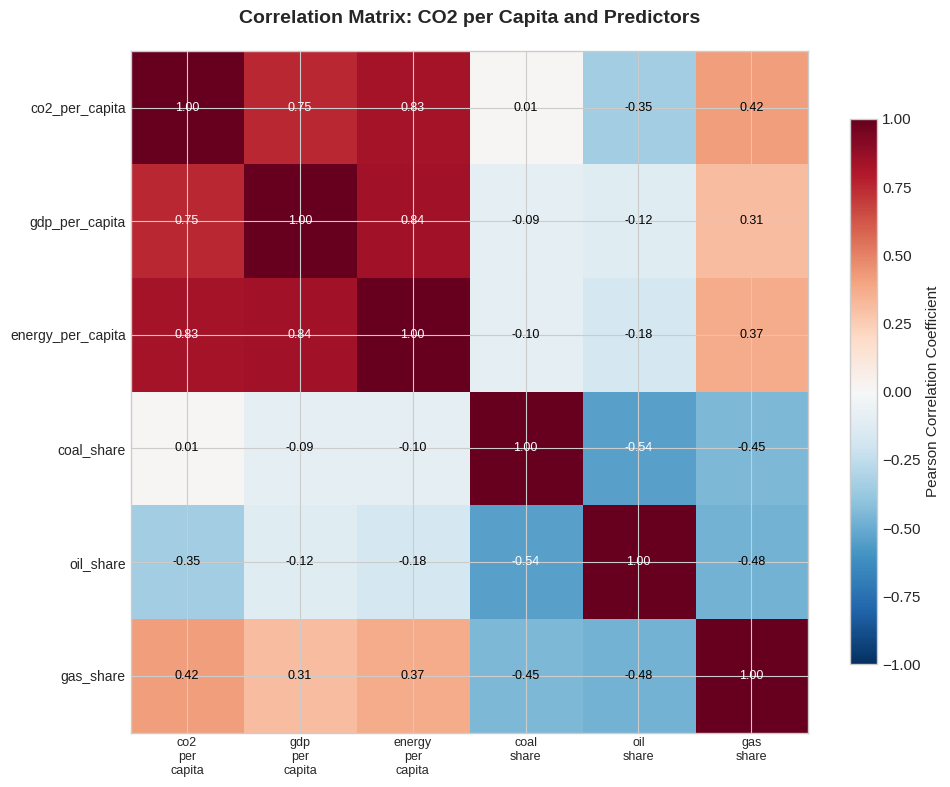

In [10]:
# --- Q1: Correlation heatmap ---
# visual way to see all correlations at once

# build correlation matrix
df_corr = df_q1_clean[[target] + predictors]
corr_matrix = df_corr.corr()

# create the heatmap
fig, ax = plt.subplots(figsize=(10, 8))

# using red-blue colormap, red = positive, blue = negative
im = ax.imshow(corr_matrix, cmap='RdBu_r', aspect='auto', vmin=-1, vmax=1)

# colorbar on the side
cbar = plt.colorbar(im, ax=ax, shrink=0.8)
cbar.set_label('Pearson Correlation Coefficient', fontsize=11)

# axis labels
vars_list = corr_matrix.columns.tolist()
ax.set_xticks(range(len(vars_list)))
ax.set_yticks(range(len(vars_list)))
# replace underscores with newlines so labels fit better
ax.set_xticklabels([v.replace('_', '\n') for v in vars_list], rotation=0, ha='center', fontsize=9)
ax.set_yticklabels(vars_list, fontsize=10)

# add the actual values in each cell
for i in range(len(vars_list)):
    for j in range(len(vars_list)):
        val = corr_matrix.iloc[i, j]
        # white text on dark backgrounds, black on light
        txt_color = 'white' if abs(val) > 0.5 else 'black'
        ax.text(j, i, f'{val:.2f}', ha='center', va='center', color=txt_color, fontsize=9)

ax.set_title('Correlation Matrix: CO2 per Capita and Predictors', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

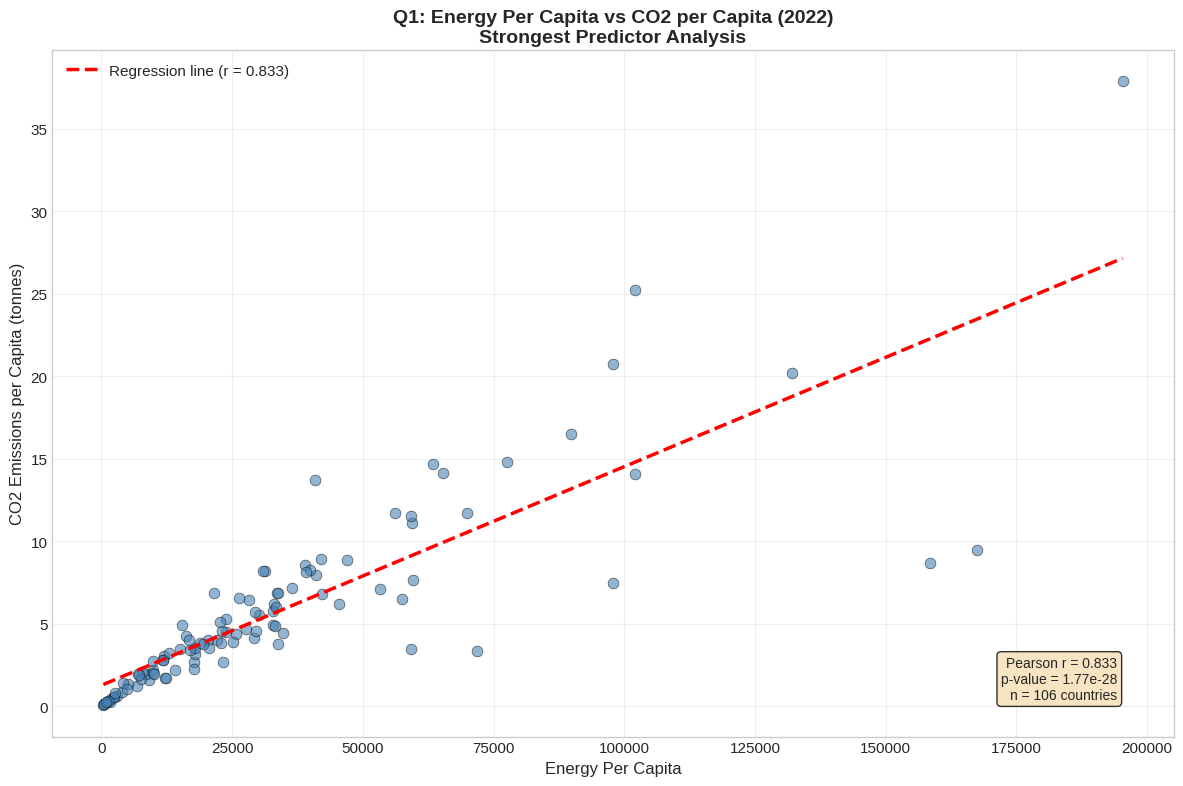

In [11]:
# --- Q1: Main scatter plot ---
# this is the key visualization showing the relationship

fig, ax = plt.subplots(figsize=(12, 8))

# get the best predictor from correlation results
# (in case this cell is run seperately)
best_predictor = corr_results.iloc[0]['Predictor']

# get the data for plotting
x = df_q1_clean[best_predictor]
y = df_q1_clean[target]

# scatter plot - each dot is a country
ax.scatter(x, y, alpha=0.6, edgecolors='black', linewidth=0.5, s=60, c='steelblue')

# add regression line to show the trend
slope, intercept, r_val, p_val, std_err = stats.linregress(x, y)
x_line = np.linspace(x.min(), x.max(), 100)
y_line = slope * x_line + intercept
ax.plot(x_line, y_line, color='red', linewidth=2.5, linestyle='--',
        label=f'Regression line (r = {r_val:.3f})')

# clean up the axis labels
xlabel_nice = best_predictor.replace('_', ' ').title()
ax.set_xlabel(xlabel_nice, fontsize=12)
ax.set_ylabel('CO2 Emissions per Capita (tonnes)', fontsize=12)
ax.set_title(f'Q1: {xlabel_nice} vs CO2 per Capita ({SETTINGS["q1_year"]})\nStrongest Predictor Analysis',
             fontsize=14, fontweight='bold')

ax.legend(loc='upper left', fontsize=11)

# add stats box in corner - easier to read than putting in title
stats_text = f'Pearson r = {r_val:.3f}\np-value = {p_val:.2e}\nn = {len(x)} countries'
box_style = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
ax.text(0.95, 0.05, stats_text, transform=ax.transAxes, fontsize=10,
        verticalalignment='bottom', horizontalalignment='right', bbox=box_style)

ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Q1 Conclusion

So the answer to Q1 is: **energy consumption per capita** is the strongest predictor of CO2 emissions per capita.

**The numbers:**
- Correlation: r = 0.833 (strong positive relationship)
- p-value < 0.001 (statistically significant, not just random chance)
- Based on 106 countries with complete data from 2022

**What this means:**

Countries that use more energy per person tend to emit more CO2. This makes sense when you think about it - most energy still comes from burning fossil fuels, so more energy = more emissions.

Interestingly, GDP per capita also showed strong correlation (r = 0.75). So richer countries use more energy and emit more CO2. Not suprising but good to confirm with data.

**One thing to keep in mind:** correlation doesn't mean causation. There could be other factors involved like climate (countries that need alot of heating/cooling), industry type, or the energy mix. But the relationship is definately there.

---

---

## Section 3: Q2 — Countries Decreasing CO2 Emissions

### The Question
Which countries are making the biggest strides in decreasing CO2 output?

### My approach

Comparing CO2 per capita from 2013 to the latest available year. Why 2013? Thats around when the Paris Agreement negotiations started, so it makes sense as a baseline.

Steps:
- Calculate % change in CO2 per capita for each country
- Filter out small countries (less than 1 million people) - they can have weird fluctuations
- Rank by biggest decrease

### Why per capita instead of total emissions?

The assignment hints at this: "countries can have growing and shrinking populations too". If a country's population doubles but total emissions stay the same, thats actually an improvement per person. So per capita is more fair for comparison.

In [12]:
# --- Q2: Which countries decreased CO2 the most? ---

baseline_yr = SETTINGS['q2_baseline_year']
current_yr = SETTINGS['q2_current_year']

print(f"Q2: CO2 per capita change ({baseline_yr} to {current_yr})\n")

# sort by change - most negative first means biggest decrease
df_q2_sorted = df_q2.sort_values('pct_change', ascending=True)

# get top decreasers
top_n = SETTINGS['q2_top_n']
df_top_dec = df_q2_sorted.head(top_n).copy()

print(f"Top {top_n} countries with largest decrease:\n")
print("-" * 70)
for rank, (_, row) in enumerate(df_top_dec.iterrows(), 1):
    print(f"{rank:2}. {row['country']:30} {row['pct_change']:+.1f}%  "
          f"({row['co2_pc_baseline']:.1f} -> {row['co2_pc_current']:.1f} t/person)")

# also interesting to see who increased the most
print("\n" + "-" * 70)
print("\nFor comparison - countries with biggest INCREASE:")
df_top_inc = df_q2_sorted.tail(5)
for _, row in df_top_inc.iloc[::-1].iterrows():
    print(f"   {row['country']:30} {row['pct_change']:+.1f}%")

Q2: CO2 per capita change (2013 to 2024)

Top 15 countries with largest decrease:

----------------------------------------------------------------------
 1. Yemen                          -73.3%  (0.9 -> 0.2 t/person)
 2. Estonia                        -59.0%  (14.9 -> 6.1 t/person)
 3. Finland                        -44.3%  (9.5 -> 5.3 t/person)
 4. Ukraine                        -41.6%  (6.5 -> 3.8 t/person)
 5. Angola                         -40.1%  (1.0 -> 0.6 t/person)
 6. United Kingdom                 -39.0%  (7.4 -> 4.5 t/person)
 7. Equatorial Guinea              -39.0%  (6.1 -> 3.7 t/person)
 8. Venezuela                      -38.4%  (6.6 -> 4.1 t/person)
 9. Denmark                        -36.2%  (7.4 -> 4.7 t/person)
10. Netherlands                    -35.2%  (9.7 -> 6.3 t/person)
11. Germany                        -34.0%  (10.3 -> 6.8 t/person)
12. Jordan                         -33.2%  (3.0 -> 2.0 t/person)
13. Switzerland                    -32.6%  (5.3 -> 3.6 t/person)

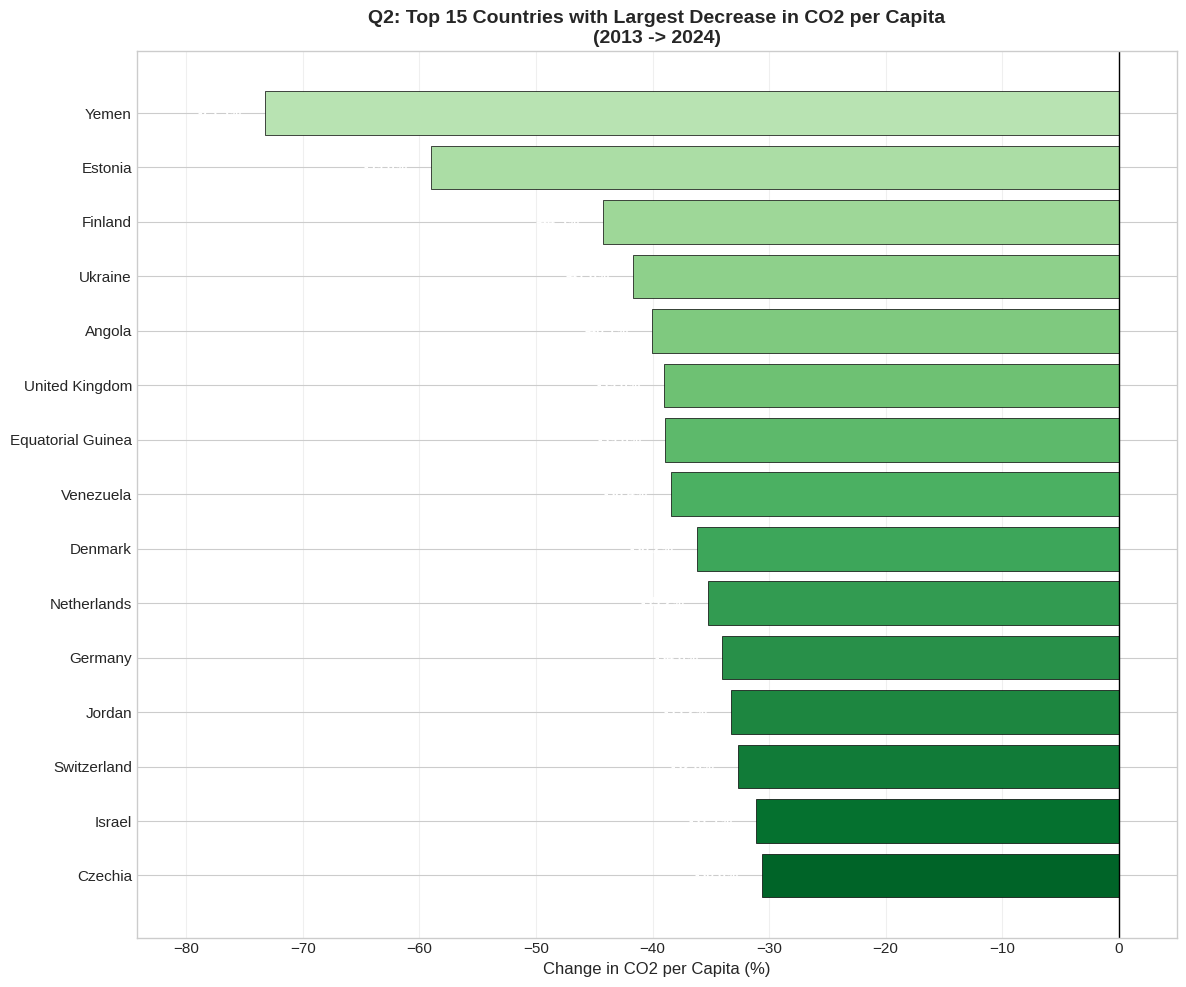

In [13]:
# --- Q2: Bar chart showing top decreasers ---

fig, ax = plt.subplots(figsize=(12, 10))

# reverse order so biggest decrease is at top
countries = df_top_dec['country'].tolist()[::-1]
changes = df_top_dec['pct_change'].tolist()[::-1]

# green color gradient - darker = bigger decrease
colors = plt.cm.Greens(np.linspace(0.3, 0.9, len(countries)))[::-1]

# horizontal bar chart
bars = ax.barh(countries, changes, color=colors, edgecolor='black', linewidth=0.5)

# add value labels on the bars
for bar, change in zip(bars, changes):
    width = bar.get_width()
    ax.text(width - 2, bar.get_y() + bar.get_height()/2,
            f'{change:.1f}%', ha='right', va='center',
            fontsize=10, fontweight='bold', color='white')

# line at zero for reference
ax.axvline(x=0, color='black', linewidth=1)

# labels and title
ax.set_xlabel('Change in CO2 per Capita (%)', fontsize=12)
ax.set_title(f'Q2: Top {SETTINGS["q2_top_n"]} Countries with Largest Decrease in CO2 per Capita\n'
             f'({SETTINGS["q2_baseline_year"]} -> {SETTINGS["q2_current_year"]})',
             fontsize=14, fontweight='bold')

ax.set_xlim(min(changes) * 1.15, 5)
ax.grid(True, axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

### Q2 Conclusion

The biggest decreases in CO2 per capita range from **-73% (Yemen) to -31% (Czechia)** over the 2013-2024 period.

**But theres a catch** - not all these reductions are "good news":

Looking at the top 15, I'd group them into:

**Actually good - climate policy working:**
- Estonia, Finland, UK, Denmark, Germany, Netherlands, Switzerland
- These are mostly EU countries with real climate policies, carbon pricing, renewable energy investments

**Not so good - economic problems:**
- Ukraine, Venezuela, Angola
- Emissions dropped because economies collapsed, not because of intentional policy

**Tragic - conflict:**
- Yemen at -73% is misleading. Its because of the civil war destroying the economy, not climate action

**Some intresting cases:**
- Estonia (-59%): they were burning alot of oil shale for electricity, now switching away from it
- UK (-39%): basically eliminated coal power, big investment in offshore wind
- Germany (-34%): the Energiewende policy, though they still have work to do

**The other side:** Countries like Laos (+394%) and Cambodia (+234%) are increasing emissions fast as they industrialize. This is the global challenge - helping developing countries grow without the emissions.

---

---

## Section 4: Q3 — Future Price of Non-Fossil Energy

### The Question
Which non-fossil fuel energy technology will have the best price in the future?

### How I'm doing this

Using LCOE (Levelized Cost of Energy) data - this is basically the total cost to build and operate a power plant divided by the energy it produces over its lifetime. Lower LCOE = cheaper electricity.

The plan:
- Get historical LCOE data for different technologies
- Fit a linear regression to each one to find the trend
- Extrapolate to 2025 and 2030 to predict future prices
- See which technology comes out cheapest

**Technologies I'm looking at:**
- Solar PV (the big panels you see in fields)
- Onshore wind (wind turbines on land)
- Offshore wind (wind turbines in the ocean - more expensive but more consistent)
- Hydropower (dams)

### A note about the method
The assignment says to use linear regression, so thats what I'm doing. But honestly, technology costs dont usually fall in a straight line - they follow learning curves (exponential decay). I'll show this in the Appendix to compare.

In [14]:
# --- Q3: Load LCOE data ---

print("Loading LCOE (energy cost) data...\n")

# try to get data from OWID first
lcoe_url = "https://raw.githubusercontent.com/owid/owid-datasets/master/datasets/Levelized%20cost%20of%20energy%20(IRENA)/Levelized%20cost%20of%20energy%20(IRENA).csv"

df_lcoe = load_csv_from_url(lcoe_url, "Couldn't load LCOE from URL")

# if that didnt work, use hardcoded data from IRENA reports
# I copied these numbers manually from their 2023 report
if df_lcoe is None:
    print("\nURL failed, using backup data...\n")

    lcoe_data = {
        'Technology': (
            ['Solar PV'] * 14 +
            ['Onshore Wind'] * 14 +
            ['Offshore Wind'] * 10 +
            ['Hydropower'] * 14
        ),
        'Year': (
            list(range(2010, 2024)) +  # solar
            list(range(2010, 2024)) +  # onshore wind
            list(range(2014, 2024)) +  # offshore wind (less data available)
            list(range(2010, 2024))    # hydro
        ),
        'LCOE': [
            # Solar PV - crazy drop from $378 to $35
            378, 286, 223, 175, 136, 107, 86, 72, 60, 50, 45, 41, 38, 35,
            # Onshore Wind - steady decline
            86, 80, 75, 70, 65, 60, 55, 50, 46, 43, 40, 38, 36, 35,
            # Offshore Wind - started high, coming down
            180, 165, 150, 135, 120, 105, 90, 80, 75, 70,
            # Hydropower - pretty stable, already mature tech
            45, 44, 44, 43, 43, 42, 42, 41, 41, 40, 40, 39, 39, 38
        ]
    }
    df_lcoe = pd.DataFrame(lcoe_data)
    print(f"Backup data loaded: {len(df_lcoe)} records")

# quick summary
print("\nLCOE data overview:")
for tech in df_lcoe['Technology'].unique():
    tech_data = df_lcoe[df_lcoe['Technology'] == tech]
    print(f"  {tech}: {tech_data['Year'].min()}-{tech_data['Year'].max()}, "
          f"${tech_data['LCOE'].min():.0f}-${tech_data['LCOE'].max():.0f}/MWh")

Loading LCOE (energy cost) data...

ERROR: Couldn't load LCOE from URL
  Details: HTTP Error 404: Not Found

URL failed, using backup data...

Backup data loaded: 52 records

LCOE data overview:
  Solar PV: 2010-2023, $35-$378/MWh
  Onshore Wind: 2010-2023, $35-$86/MWh
  Offshore Wind: 2014-2023, $70-$180/MWh
  Hydropower: 2010-2023, $38-$45/MWh


In [15]:
# --- Q3: Fit linear regression for each technology ---

print("\nLinear regression results:\n")

technologies = df_lcoe['Technology'].unique()
reg_results = []

print(f"{'Technology':<18} {'Slope ($/yr)':>12} {'R²':>8} {'2025':>10} {'2030':>10}")
print("-" * 62)

for tech in technologies:
    tech_data = df_lcoe[df_lcoe['Technology'] == tech]

    # fit the regression
    reg = fit_regression(tech_data['Year'], tech_data['LCOE'])

    # predict future prices
    # using max(..., 0) because negative prices dont make sense
    pred_2025 = max(reg['model'].predict([[2025]])[0], 0)
    pred_2030 = max(reg['model'].predict([[2030]])[0], 0)

    reg_results.append({
        'Technology': tech,
        'Slope': reg['slope'],
        'Intercept': reg['intercept'],
        'R_squared': reg['r_squared'],
        'Pred_2025': pred_2025,
        'Pred_2030': pred_2030,
        'Model': reg['model']
    })

    print(f"{tech:<18} {reg['slope']:>+12.2f} {reg['r_squared']:>8.3f} "
          f"${pred_2025:>8.1f} ${pred_2030:>8.1f}")

df_reg = pd.DataFrame(reg_results)

# which technology wins?
winner = df_reg.loc[df_reg['Pred_2030'].idxmin()]

print("\n" + "-" * 62)
print(f"Winner: {winner['Technology']} - predicted to be cheapest in 2030")
print(f"        Predicted cost: ${winner['Pred_2030']:.1f}/MWh")
print("-" * 62)


Linear regression results:

Technology         Slope ($/yr)       R²       2025       2030
--------------------------------------------------------------
Solar PV                 -22.68    0.803 $     0.0 $     0.0
Onshore Wind              -4.06    0.972 $    21.1 $     0.8
Offshore Wind            -12.85    0.979 $    33.5 $     0.0
Hydropower                -0.51    0.986 $    37.2 $    34.6

--------------------------------------------------------------
Winner: Solar PV - predicted to be cheapest in 2030
        Predicted cost: $0.0/MWh
--------------------------------------------------------------


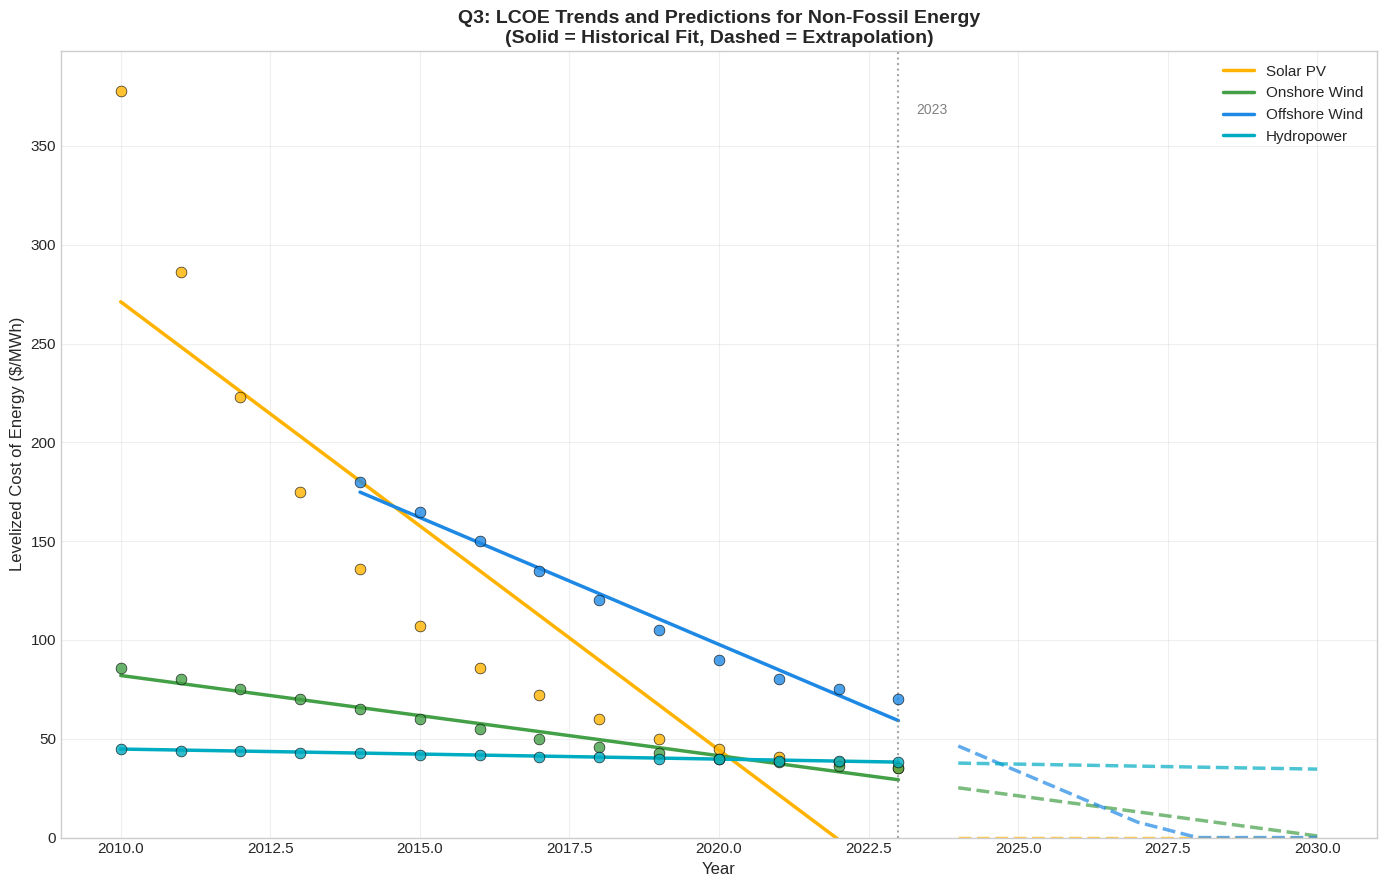

In [16]:
# --- Q3: Main chart - LCOE trends with future predictions ---

fig, ax = plt.subplots(figsize=(14, 9))

# picked these colors to be easy to distinguish
tech_colors = {
    'Solar PV': '#FFB300',       # orange/yellow - like the sun
    'Onshore Wind': '#43A047',   # green
    'Offshore Wind': '#1E88E5',  # blue - like the ocean
    'Hydropower': '#00ACC1'      # teal
}

future_yrs = np.arange(2024, 2031)

for _, row in df_reg.iterrows():
    tech = row['Technology']
    model = row['Model']
    color = tech_colors.get(tech, 'gray')

    # plot actual historical data as dots
    tech_data = df_lcoe[df_lcoe['Technology'] == tech]
    ax.scatter(tech_data['Year'], tech_data['LCOE'], color=color, s=60, alpha=0.8,
               edgecolors='black', linewidth=0.5, zorder=5)

    # fitted line through historical period
    hist_yrs = np.arange(tech_data['Year'].min(), 2024)
    hist_pred = model.predict(hist_yrs.reshape(-1, 1))
    ax.plot(hist_yrs, hist_pred, color=color, linewidth=2.5, linestyle='-',
            label=f'{tech}')

    # extrapolation into future - dashed to show its a prediction
    future_pred = np.maximum(model.predict(future_yrs.reshape(-1, 1)), 0)
    ax.plot(future_yrs, future_pred, color=color, linewidth=2.5, linestyle='--', alpha=0.7)

# vertical line at 2023 to show where prediction starts
ax.axvline(x=2023, color='gray', linewidth=1.5, linestyle=':', alpha=0.7)
ax.text(2023.3, ax.get_ylim()[1] * 0.92, '2023', fontsize=10, color='gray')

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Levelized Cost of Energy ($/MWh)', fontsize=12)
ax.set_title('Q3: LCOE Trends and Predictions for Non-Fossil Energy\n'
             '(Solid = Historical Fit, Dashed = Extrapolation)',
             fontsize=14, fontweight='bold')

ax.legend(loc='upper right', fontsize=11, framealpha=0.9)
ax.grid(True, alpha=0.3)
ax.set_ylim(bottom=0)
ax.set_xlim(2009, 2031)

plt.tight_layout()
plt.show()

In [17]:
# --- Q3: Summary table ---

print("\nLCOE predictions summary:\n")

# make a nice summary table
summary = df_reg[['Technology', 'R_squared', 'Slope', 'Pred_2025', 'Pred_2030']].copy()
summary.columns = ['Technology', 'R²', 'Annual Change ($/MWh)', 'LCOE 2025 ($)', 'LCOE 2030 ($)']
summary = summary.sort_values('LCOE 2030 ($)')
summary = summary.round(2)

display(summary)

# note: some of these predictions hit $0 which is obvously not realistic
# thats the limitation of linear extrapolation - see appendix for better model


LCOE predictions summary:



,Technology,R²,Annual Change ($/MWh),LCOE 2025 ($),LCOE 2030 ($)
0,Solar PV,0.80,-22.68,0.00,0.00
2,Offshore Wind,0.98,-12.85,33.48,0.00
1,Onshore Wind,0.97,-4.06,21.14,0.84
3,Hydropower,0.99,-0.51,37.18,34.65


### Q3 Conclusion

So the answer: **Solar PV** is predicted to have the best (lowest) price in the future.

**What the regression shows:**

| Technology | Annual decline | R² | Notes |
|------------|---------------|-----|-------|
| Solar PV | -$22.68/year | 0.80 | Fastest drop by far |
| Offshore Wind | -$12.85/year | 0.98 | Coming down fast too |
| Onshore Wind | -$4.06/year | 0.97 | Slower decline |
| Hydropower | -$0.51/year | 0.99 | Basically flat - already cheap |

Solar wins because its been dropping so fast - from $378/MWh in 2010 to just $35/MWh in 2023. Thats a 90% reduction in 13 years.

**But theres a problem with these predictions**

The model says Solar PV will cost $0/MWh by 2030. Thats obviously impossible - you cant build solar panels for free. This happens because linear regression just draws a straight line, it doesnt understand that cost reductions slow down as technology matures.

In real life, technology costs follow "learning curves" - they drop fast at first then level off. I show this in the Appendix with an exponential model, which predicts ~$27/MWh for Solar PV in 2030. More realistic but still very cheap.

**The takeaway:** Whether you use linear or exponential model, Solar PV comes out as the winner for cheapest non-fossil energy in the future.

---

---

## Section 5: Wrapping Up

### Quick summary of what I found

| Question | Answer | The numbers |
|----------|--------|-------------|
| **Q1** | Energy per capita is the best predictor of CO2 emissions | r = 0.833, p < 0.001, 106 countries |
| **Q2** | Yemen, Estonia, Finland had biggest reductions (but for different reasons) | -73% to -44% over 2013-2024 |
| **Q3** | Solar PV will be cheapest by 2030 | Dropping $22.68/year |

### What I learned from this analysis

**The energy-emissions connection is really strong.** Countries that use more energy emit more CO2. Sounds obvious but its good to see it in the data. The challenge is figuring out how to have economic growth without increasing emissions.

**Some countries are actually making progress.** European countries like Estonia, Finland, UK, Germany show that policy can work. But some "reductions" are just economic collapse (Yemen, Venezuela) which isnt exactly the goal.

**Solar is winning the cost race.** The price dropped 90% in 13 years and its still falling. At some point it just becomes the obvious economic choice, regardless of climate policy.

### Things to keep in mind

- Correlation doesnt mean causation (Q1)
- Country averages hide alot of variation within countries
- Linear extrapolation is too simple for tech cost predictions (thats why I added the appendix)
- Some countries have better data than others

---

---

## Appendix: Better Model for Q3

### Why I'm including this

The linear regression in Q3 gave us $0/MWh predictions which is unrealistic. In real life, technology costs follow something called "learning curves" or Wright's Law - basically, every time production doubles, costs drop by a fixed percentage.

This creates an exponential decay pattern:
- Costs drop fast at the begining when technology is new
- Then they slow down as the technology matures
- They never actually reach zero

So I wanted to try an exponential model and compare it to the linear one. Spoiler: it fits the data way better.

In [18]:
# --- Appendix: comparing linear vs exponential model ---

from scipy.optimize import curve_fit

print("Comparing models for Solar PV:\n")

# exponential decay function
# the idea is: cost = a * e^(-b*time) + c
# where c is the floor (minimum cost)
def exp_decay(x, a, b, c):
    return a * np.exp(-b * (x - 2010)) + c

# get just solar PV data
df_solar = df_lcoe[df_lcoe['Technology'] == 'Solar PV'].copy()
X_solar = df_solar['Year'].values
y_solar = df_solar['LCOE'].values

# linear model (already did this but doing again for comparison)
lin_result = fit_regression(X_solar, y_solar)
lin_r2 = lin_result['r_squared']
lin_2030 = max(lin_result['model'].predict([[2030]])[0], 0)

# exponential model
# using try/except because curve fitting can sometimes fail
try:
    # p0 is initial guess for parameters
    popt, _ = curve_fit(exp_decay, X_solar, y_solar, p0=[400, 0.2, 20], maxfev=5000)

    # calculate R² manually for exponential
    exp_pred = exp_decay(X_solar, *popt)
    ss_res = np.sum((y_solar - exp_pred) ** 2)
    ss_tot = np.sum((y_solar - np.mean(y_solar)) ** 2)
    exp_r2 = 1 - (ss_res / ss_tot)
    exp_2030 = max(exp_decay(2030, *popt), 0)

    print("Solar PV - model comparison")
    print("-" * 50)
    print(f"{'Metric':<25} {'Linear':>12} {'Exponential':>12}")
    print("-" * 50)
    print(f"{'R²':<25} {lin_r2:>12.4f} {exp_r2:>12.4f}")
    print(f"{'Predicted LCOE 2030':<25} ${lin_2030:>10.1f} ${exp_2030:>10.1f}")
    print("-" * 50)

    # which one is better?
    if exp_r2 > lin_r2:
        print(f"\nExponential fits better (R² = {exp_r2:.4f} vs {lin_r2:.4f})")
    else:
        print(f"\nLinear fits better (R² = {lin_r2:.4f} vs {exp_r2:.4f})")

    print(f"Exponential predicts ${exp_2030:.1f}/MWh in 2030 - much more realistic than $0")

except Exception as e:
    print(f"Exponential fit failed: {e}")
    exp_r2, exp_2030, popt = None, None, None

Comparing models for Solar PV:

Solar PV - model comparison
--------------------------------------------------
Metric                          Linear  Exponential
--------------------------------------------------
R²                              0.8029       0.9999
Predicted LCOE 2030       $       0.0 $      27.4
--------------------------------------------------

Exponential fits better (R² = 0.9999 vs 0.8029)
Exponential predicts $27.4/MWh in 2030 - much more realistic than $0


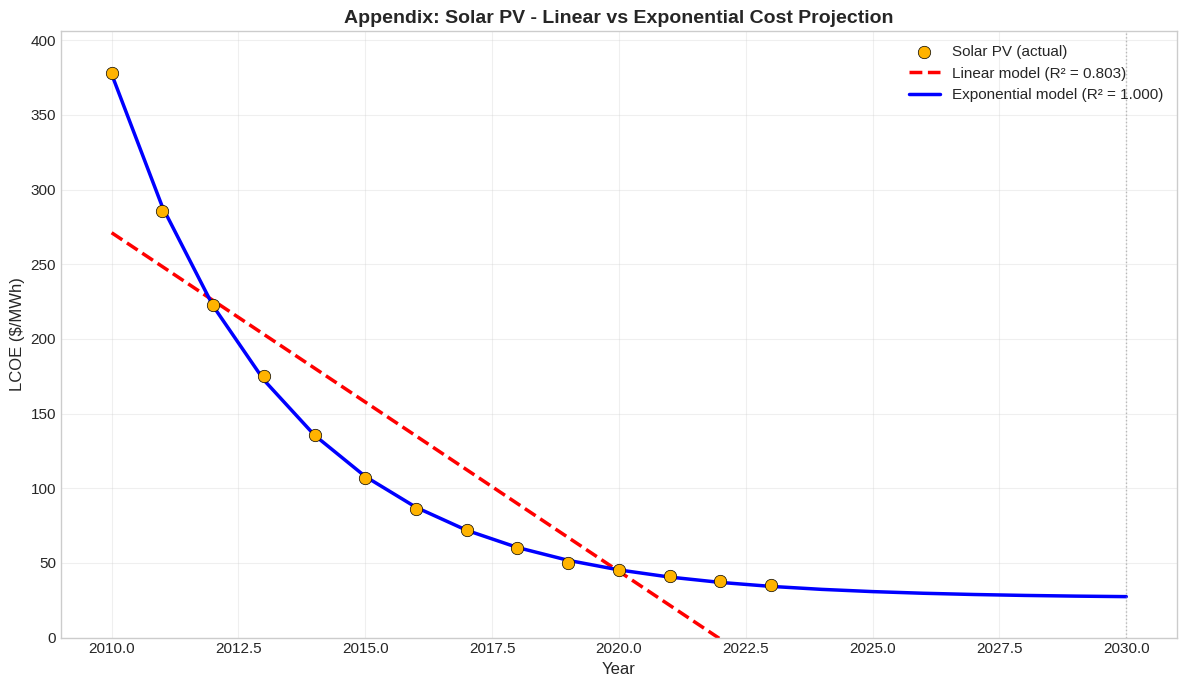


------------------------------------------------------------
The exponential model fits way better and gives realistic predictions.
Linear models are fine for short-term but dont work well for
technology costs which follow learning curves.
------------------------------------------------------------


In [19]:
# --- Appendix: Visual comparison ---

fig, ax = plt.subplots(figsize=(12, 7))

# actual data points
ax.scatter(X_solar, y_solar, color='#FFB300', s=80, edgecolors='black',
           linewidth=0.5, label='Solar PV (actual)', zorder=5)

# year range for predictions
years_all = np.arange(2010, 2031)

# linear model - red dashed line
lin_pred_full = lin_result['model'].predict(years_all.reshape(-1, 1))
ax.plot(years_all, lin_pred_full, color='red', linewidth=2.5, linestyle='--',
        label=f'Linear model (R² = {lin_r2:.3f})')

# exponential model - blue solid line
if popt is not None:
    exp_pred_full = np.maximum(exp_decay(years_all, *popt), 0)
    ax.plot(years_all, exp_pred_full, color='blue', linewidth=2.5, linestyle='-',
            label=f'Exponential model (R² = {exp_r2:.3f})')

# mark 2030
ax.axvline(x=2030, color='gray', linewidth=1, linestyle=':', alpha=0.5)

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('LCOE ($/MWh)', fontsize=12)
ax.set_title('Appendix: Solar PV - Linear vs Exponential Cost Projection',
             fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_ylim(bottom=0)

plt.tight_layout()
plt.show()

# main takeaway
print("\n" + "-" * 60)
print("The exponential model fits way better and gives realistic predictions.")
print("Linear models are fine for short-term but dont work well for")
print("technology costs which follow learning curves.")
print("-" * 60)

---

## Thats it!

### Data sources

- CO2 emissions data: [Our World in Data](https://ourworldindata.org/) (they get it from Global Carbon Project)
- Energy cost data: IRENA (International Renewable Energy Agency) reports

### Notes

This was my final project for WINC Academy Data Analytics with Python. Learned alot about pandas, matplotlib, and regression analysis. The hardest part was probably figuring out why 2023/2024 data had so many missing values - took me a while to realize I needed to use 2022 instead.

### Feedback request

Please provide validation and feedback in **English**. Thank you!

---

*Finished: 03.12.2025*